# Making a Deep Convolution WGAN with Gradient Penalty (and maybe Self-Attention if all goes smooth)

## Boring imports and datasets (Same for most of the Notebooks that use MNIST)

In [1]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import sklearn.model_selection as ms
from tqdm import tqdm,trange
import albumentations as A
from torchvision import transforms
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [2]:
class Hyperparams:
    num_epochs = 40
    discriminator_lr = 1e-4
    generator_lr = 1e-4
    num_latent_features = 100
    
    discriminator_steps = 5
    grad_penalty_lambda = 10 
    
    normalise_transform = transforms.Compose([
        transforms.Normalize(mean=(0.5), std=(0.5))
        ])

In [3]:
class MNIST_Dataset(Dataset):
    def __init__(self, metadata_df, images, normalise_transform = Hyperparams.normalise_transform ):
        self.metadata_df = metadata_df
        self.images = images
        self.normalise_transform = normalise_transform

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self,idx):
        idx = int(idx)

        image = torch.tensor(images[idx]).unsqueeze(0)
        label = torch.tensor([1])

        if self.normalise_transform:
            image = self.normalise_transform(image.float())

        return image, label

In [4]:
metadata = pd.read_csv('data/MNIST/metadata.csv')
train_metadata, valid_metadata = ms.train_test_split(metadata, test_size=0.2, train_size=0.8, random_state=19, shuffle=True, stratify=metadata['labels'])

images = np.load('data/MNIST/images.npy') / 255

In [5]:
train_dataset = MNIST_Dataset(train_metadata.reset_index(), images[train_metadata.index])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)

valid_dataset = MNIST_Dataset(valid_metadata.reset_index(), images[valid_metadata.index])
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=256)

## Fun part: models

In [6]:
# The discimininator is now called a Critic bc the outputs can be any number (so not between 0 and 1) but it comes down to the same thing

class Generator(nn.Module):
    def __init__(self,num_latent_features):
        super(Generator, self).__init__()

        self.first_linear = nn.Sequential(
            nn.Linear(num_latent_features,1024),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.InstanceNorm2d(512, affine=True),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.InstanceNorm2d(256, affine=True),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
        
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.ReLU(),
        
            nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.first_linear(x).view(-1,1024,1,1)
        x = self.decoder(x);
        return x

class Discriminator(nn.Module):
    def __init__(self,num_embeddings):
        super(Discriminator, self).__init__()
        self.num_embeddings = num_embeddings

        self.encoder = nn.Sequential(
            # 32x32 to 28x28
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=0),
            nn.InstanceNorm2d(64, affine=True),
            nn.LeakyReLU(0.1),
            
            # 28x28 to 14x14
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.1),
        
            # 14x14 to 7x7
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.1),
        
            # 7x7 to 3x3
            nn.Conv2d(256, 512, kernel_size=2, stride=2),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.1),
        
            # 3x3 to 1x1
            nn.Conv2d(512, self.num_embeddings, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(0.1),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.num_embeddings, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128,1),
        )

    def forward(self, x):
        x = self.encoder(x).view(-1,self.num_embeddings)
        x = self.classifier(x)
        return x



#Init all wieghts but a value sampled from a (0,0.02) Normal distrib (Very important for Vanilla GAN convergence)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1 or classname.find('Instance') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Train / Valid (and Gradient Penalty implementation)

In [7]:
def gradient_penalty(discriminator, real_images, fake_images, device):
    alpha = torch.rand((real_images.shape[0],1,1,1)).to(device)

    interpolated_images = alpha* real_images + (1-alpha) * fake_images
    interpolated_images.requires_grad = True

    interpolated_images_credibility = discriminator(interpolated_images)

    ones = torch.ones_like(interpolated_images_credibility)
    grad_params = torch.autograd.grad(outputs = interpolated_images_credibility, inputs = interpolated_images, create_graph= True, grad_outputs= ones)[0]

    grad_norm = grad_params.view(grad_params.size(0), -1).norm(2, dim = 1)
    grad_penalty = torch.mean((grad_norm -1 ) ** 2)
    
    return grad_penalty

In [8]:
def train(train_loader, generator, discriminator, device, g_optimizer, d_optimizer, distribution,epoch):
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    d_losses = []
    g_losses = []
        
    for index, batch in enumerate(tqdm(train_loader, total = len(train_loader))):

        #First Step -> Discriminator training
        discriminator.train()
        generator.eval()
        
        images, _ = batch
        real_images = images.to(device)

        for _ in range(Hyperparams.discriminator_steps):
            latent_samples = distribution.sample((real_images.shape[0], Hyperparams.num_latent_features)).to(device)
            with torch.no_grad():
                fake_images = generator(latent_samples)

            discriminator_real_score = discriminator(real_images)
            discriminator_fake_score = discriminator(fake_images)

            grad_penalty = gradient_penalty(discriminator, real_images, fake_images, device)

            discriminator_loss = (torch.mean(discriminator_real_score) - torch.mean(discriminator_fake_score)) #Discriminator job is for this value to be the biggest possible
            discriminator_loss = -discriminator_loss + Hyperparams.grad_penalty_lambda * grad_penalty # Goal of getting max -> now is min and add gradient penalty

            d_losses.append(discriminator_loss.item())
            d_optimizer.zero_grad()
            discriminator_loss.backward()
            d_optimizer.step()


        #Second Step -> Generator training
        discriminator.eval()
        generator.train()
        
        latent_samples = distribution.sample((real_images.shape[0], Hyperparams.num_latent_features)).to(device)
        fake_images = generator(latent_samples)

        credibility = torch.mean(discriminator(fake_images))
        generator_loss = -credibility #Goal for the generator is to have the highest credibility for his images (so the lower negative credibility)
        
        g_losses.append(generator_loss.item())
        g_optimizer.zero_grad()
        generator_loss.backward()
        g_optimizer.step()
    
    mean_d_loss = np.mean(d_losses)
    mean_g_loss = np.mean(g_losses)
    print(f'Training Discriminator loss : {mean_d_loss} | Training Generator loss : {mean_g_loss}')

In [9]:
def validate(valid_loader, generator, discriminator, device, distribution, fixed_latent_vectors,epoch):
    discriminator.eval()
    generator.eval()
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)

    with torch.no_grad():
        for index, batch in enumerate(tqdm(valid_loader, total = len(valid_loader))):
    
            #First Step -> Validate Discriminator
            images, _ = batch
            real_images = images.to(device)
            latent_samples = distribution.sample((real_images.shape[0], Hyperparams.num_latent_features)).to(device)
            fake_images = generator(latent_samples)
            images = torch.cat([real_images,fake_images])
            
            ones, zeros = torch.ones(real_images.shape[0]), torch.zeros(fake_images.shape[0])
            labels = torch.cat([ones,zeros],0).unsqueeze(1).to(device)
            
            random_indices =  torch.randperm(images.shape[0])
            images = images[random_indices]
            labels = labels[random_indices]
    
            discriminator_outputs = discriminator(images)
            discriminator_preds = torch.sigmoid(discriminator_outputs)
            
            all_preds = torch.cat([all_preds,discriminator_preds], 0)
            all_labels = torch.cat([all_labels,labels], 0)
    
        
        accuracy = (((all_preds > 0.5) == all_labels).sum() / all_labels.shape[0]).item()
        print(f'Valid Discriminator accuracy : {accuracy}')
    
        #Second Step -> Validate Generator
        fixed_latent_vectors = fixed_latent_vectors.to(device)
        fake_images = generator(fixed_latent_vectors)
        credibility = discriminator(fake_images)

        fake_images_np = fake_images.cpu().detach().numpy()
        credibility_np = credibility.cpu().detach().numpy()
        
        fig, axes = plt.subplots(5, 5, figsize=(8, 8))  # Change the subplot dimensions to 5x5
        
        # Assume fake_images_np is (25, latent_space) and credibility_np is (25,)
        for i in range(5):
            for j in range(5):
                ax = axes[i, j]
                img = fake_images_np[5 * i + j]
                score = credibility_np[5 * i + j]
                ax.imshow(img[0], cmap='gray')
                ax.set_title(f"Credibility: {score.item():.1f}")
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()


        return accuracy, fig

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(num_latent_features = Hyperparams.num_latent_features).to(device)
generator.apply(weights_init)
discriminator = Discriminator(num_embeddings = 1024).to(device)
discriminator.apply(weights_init)

distribution = torch.distributions.Normal(0, 1)
fixed_latent_vectors = distribution.sample((25, Hyperparams.num_latent_features))


d_optimizer = optim.Adam(discriminator.parameters(), lr=Hyperparams.discriminator_lr, betas=(0, 0.9))
g_optimizer = optim.Adam(generator.parameters(), lr=Hyperparams.generator_lr, betas=(0, 0.9))

Epoch 1/40


100%|██████████| 438/438 [03:00<00:00,  2.42it/s]


Training Discriminator loss : -4.220943378041324 | Training Generator loss : 0.7874585051099093


100%|██████████| 55/55 [00:01<00:00, 29.90it/s]


Valid Discriminator accuracy : 1.0


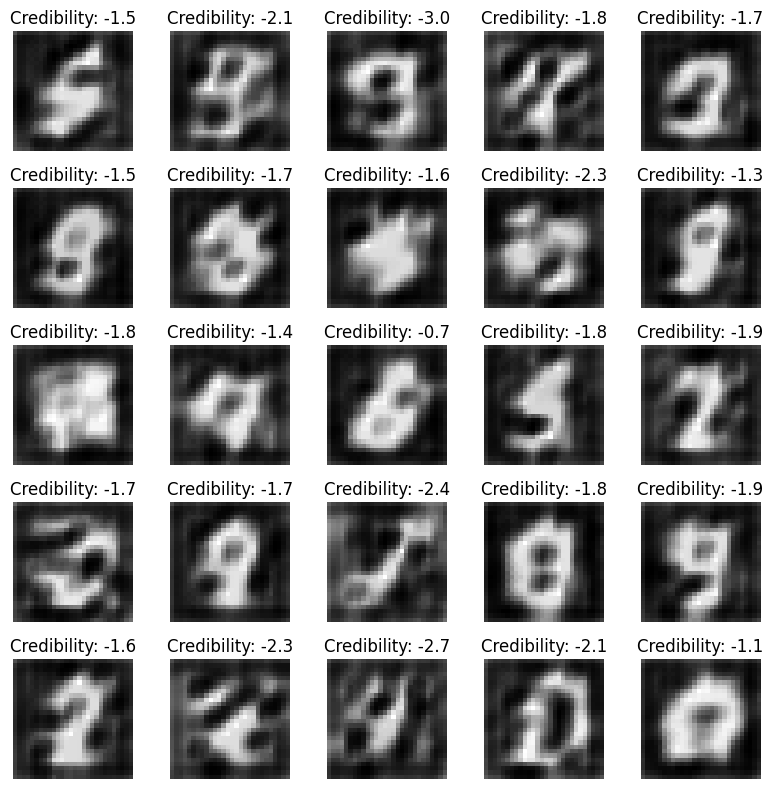

----------------------------------------------------------------------------------------------------
Epoch 2/40


100%|██████████| 438/438 [02:59<00:00,  2.44it/s]


Training Discriminator loss : -9.083135960635529 | Training Generator loss : 1.6320312078957144


100%|██████████| 55/55 [00:01<00:00, 29.41it/s]


Valid Discriminator accuracy : 0.9999285340309143


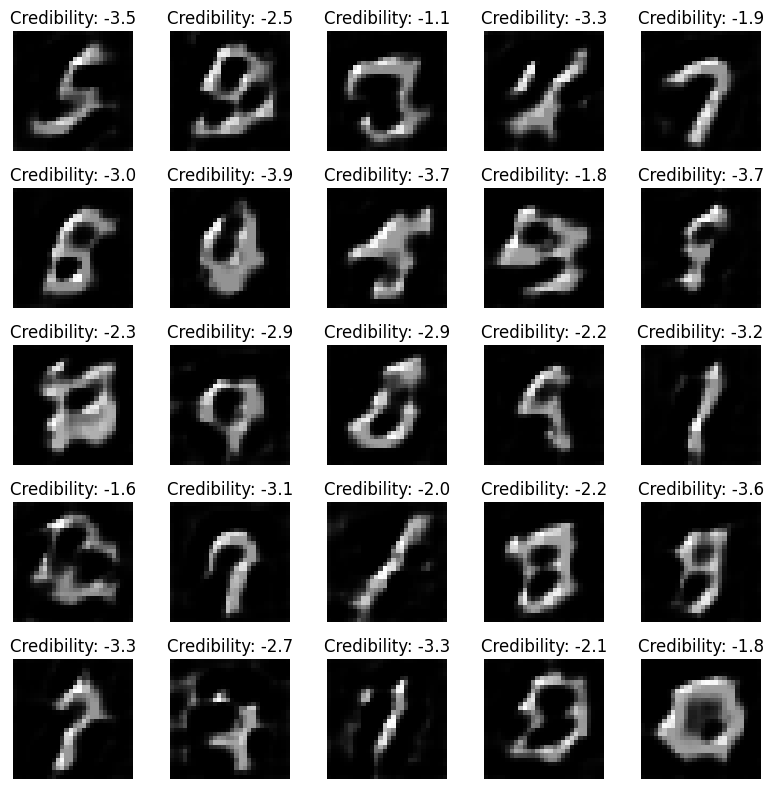

----------------------------------------------------------------------------------------------------
Epoch 3/40


100%|██████████| 438/438 [02:59<00:00,  2.43it/s]


Training Discriminator loss : -7.110434605432972 | Training Generator loss : 1.7083430045888202


100%|██████████| 55/55 [00:01<00:00, 30.29it/s]


Valid Discriminator accuracy : 0.9872857332229614


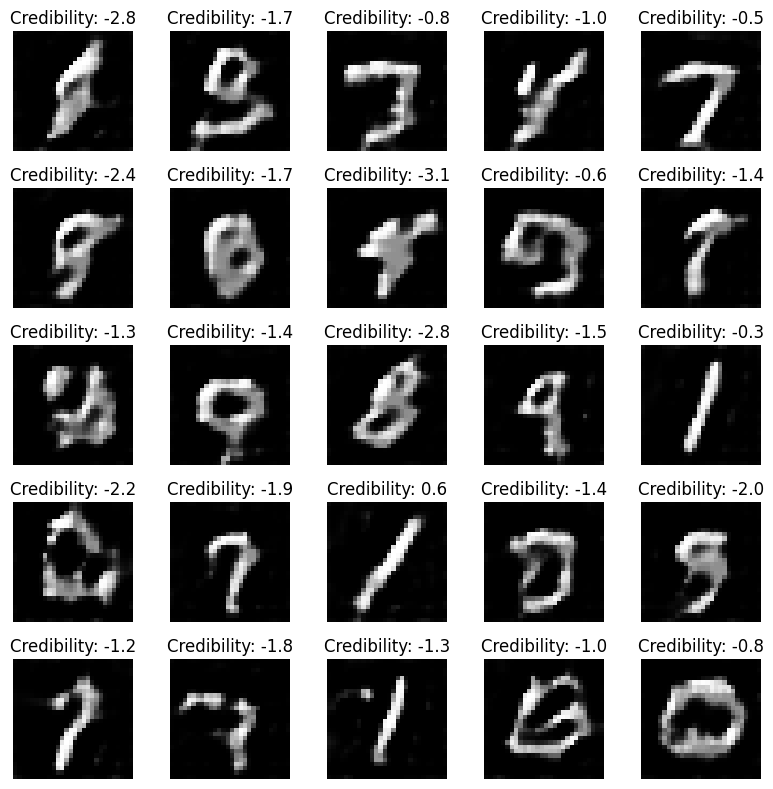

----------------------------------------------------------------------------------------------------
Epoch 4/40


100%|██████████| 438/438 [02:59<00:00,  2.43it/s]


Training Discriminator loss : -4.96551813818004 | Training Generator loss : 1.1396701637289772


100%|██████████| 55/55 [00:01<00:00, 30.31it/s]


Valid Discriminator accuracy : 0.7082856893539429


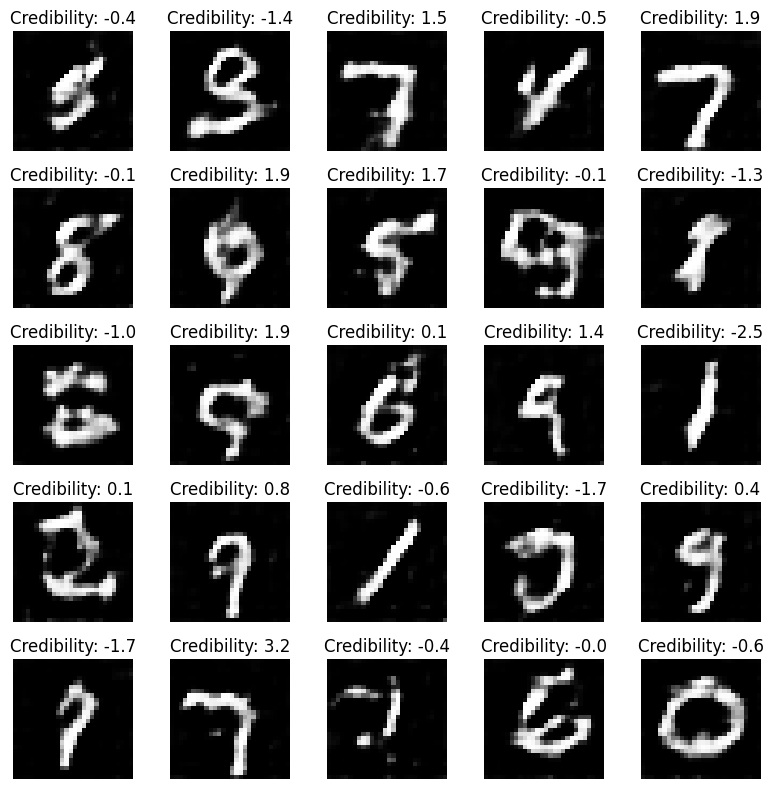

----------------------------------------------------------------------------------------------------
Epoch 5/40


100%|██████████| 438/438 [02:58<00:00,  2.46it/s]


Training Discriminator loss : -3.6975556511857195 | Training Generator loss : -0.987621253096928


100%|██████████| 55/55 [00:01<00:00, 30.36it/s]


Valid Discriminator accuracy : 0.6852856874465942


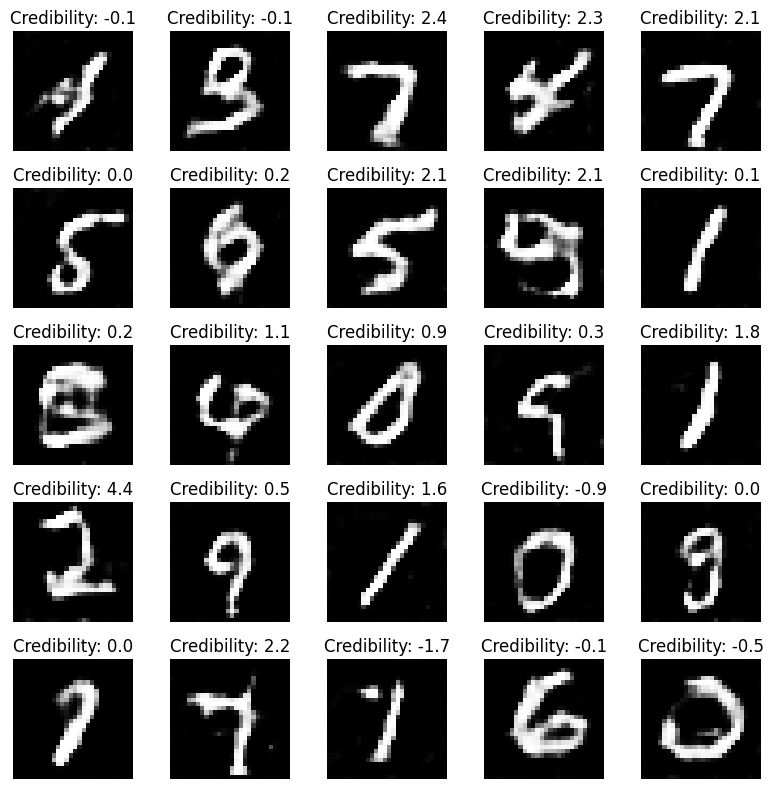

----------------------------------------------------------------------------------------------------
Epoch 6/40


100%|██████████| 438/438 [02:59<00:00,  2.44it/s]


Training Discriminator loss : -3.138800828097618 | Training Generator loss : -3.100250884805504


100%|██████████| 55/55 [00:01<00:00, 30.30it/s]


Valid Discriminator accuracy : 0.5


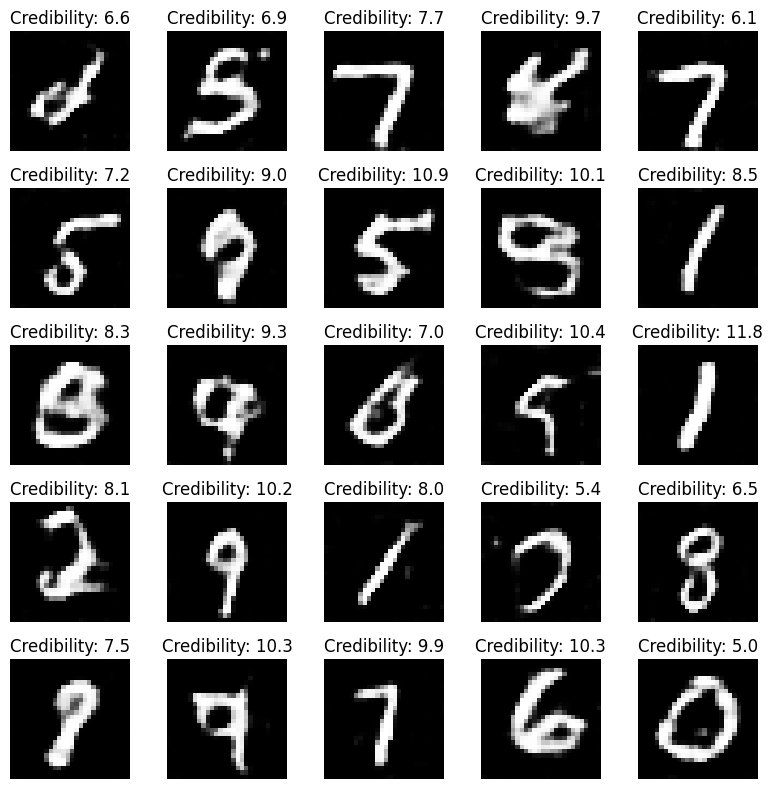

----------------------------------------------------------------------------------------------------
Epoch 7/40


100%|██████████| 438/438 [02:59<00:00,  2.44it/s]


Training Discriminator loss : -2.7879032567755817 | Training Generator loss : -4.200055302073967


100%|██████████| 55/55 [00:01<00:00, 30.40it/s]


Valid Discriminator accuracy : 0.5


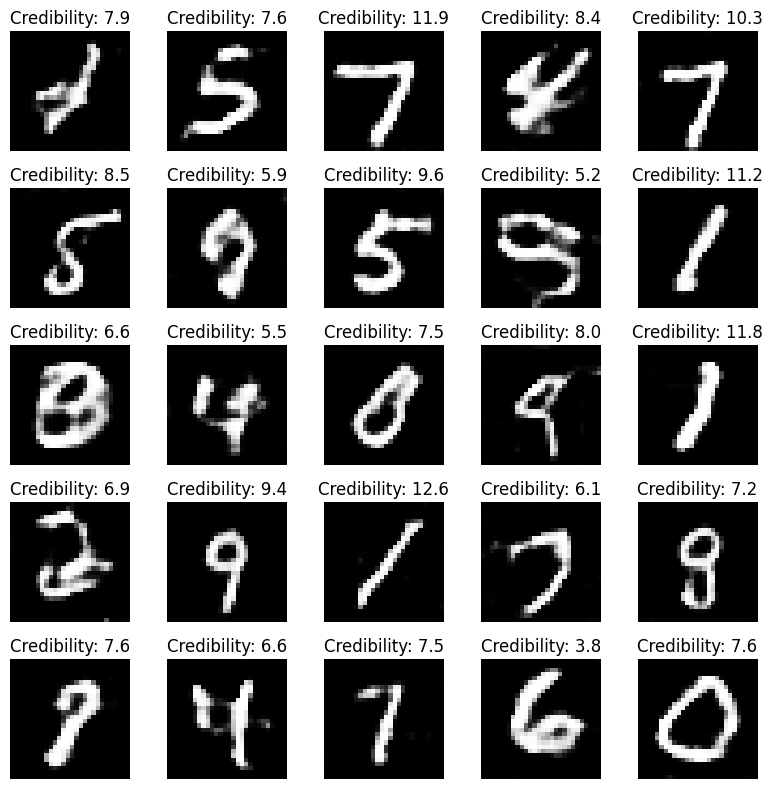

----------------------------------------------------------------------------------------------------
Epoch 8/40


100%|██████████| 438/438 [02:59<00:00,  2.44it/s]


Training Discriminator loss : -2.5506269296010333 | Training Generator loss : -4.6074005134709894


100%|██████████| 55/55 [00:01<00:00, 30.36it/s]


Valid Discriminator accuracy : 0.5001428723335266


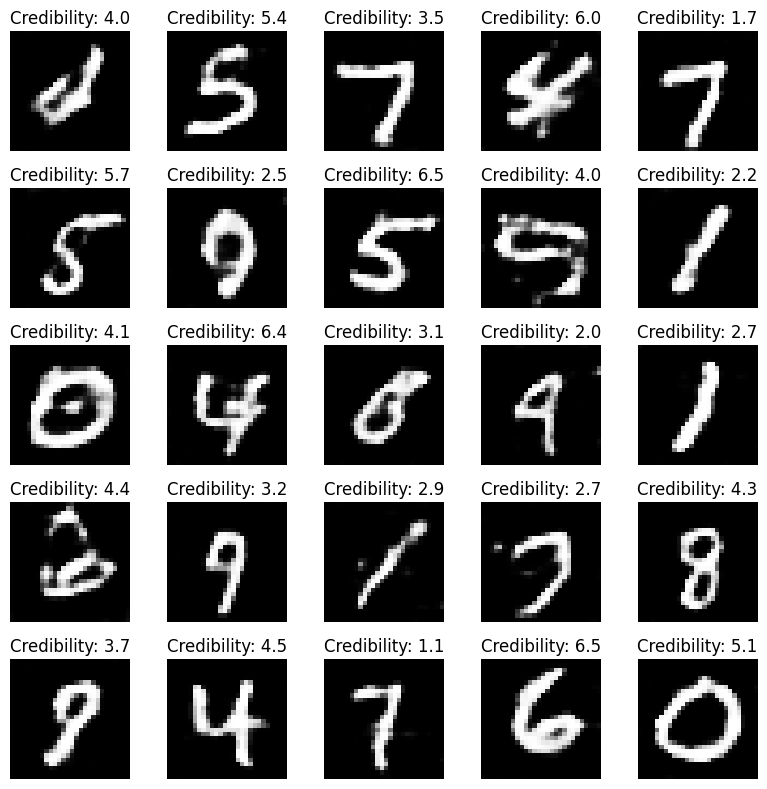

----------------------------------------------------------------------------------------------------
Epoch 9/40


100%|██████████| 438/438 [02:57<00:00,  2.47it/s]


Training Discriminator loss : -2.3769888712663083 | Training Generator loss : -4.510290669898192


100%|██████████| 55/55 [00:01<00:00, 31.87it/s]


Valid Discriminator accuracy : 0.5000714063644409


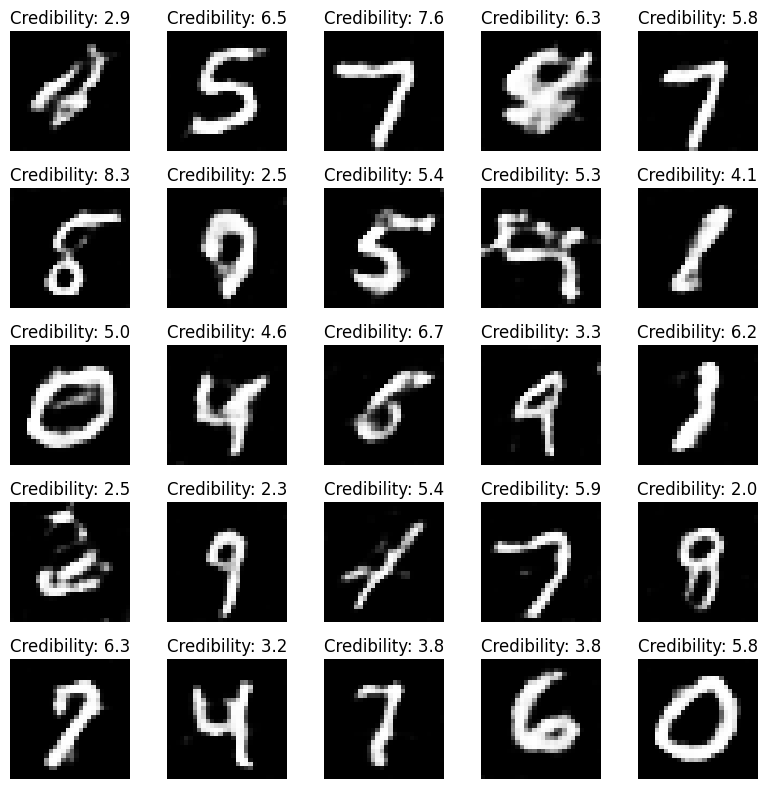

----------------------------------------------------------------------------------------------------
Epoch 10/40


  6%|▌         | 26/438 [00:10<02:52,  2.39it/s]


KeyboardInterrupt: 

In [11]:
figs = []
for epoch in range(Hyperparams.num_epochs):
    print(f'Epoch {epoch +1}/{Hyperparams.num_epochs}')
    train(train_loader, generator, discriminator, device, g_optimizer, d_optimizer, distribution, epoch)
    accuracy, fig = validate(valid_loader, generator, discriminator, device, distribution, fixed_latent_vectors,epoch)
    figs.append(fig)
    print(f'-' *100)